In [15]:
import numpy as np
import matplotlib.pyplot as plt

import os

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

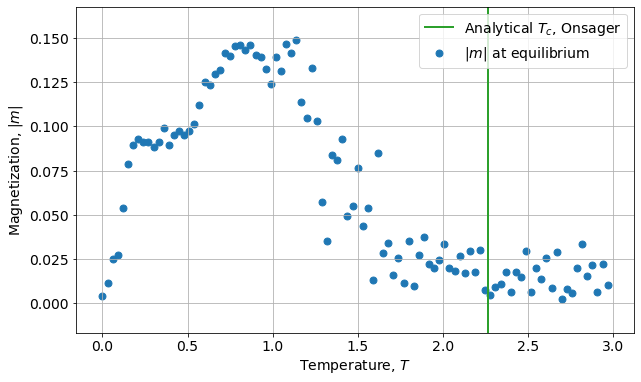

In [46]:
path = 'problem3_output/N=128/'
data = np.loadtxt(path + 'magnetization.dat')
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data[:,0], np.abs(data[:,1]), s=48, label=r'$|m|$ at equilibrium')
ax.grid()
ax.set_xlabel(r'Temperature, $T$')
ax.set_ylabel(r'Magnetization, $|m|$')
Tc = 2/np.log(1 + np.sqrt(2))
ax.axvline(Tc, color='C2', linewidth=2, label=r'Analytical $T_c$, Onsager')
ax.legend(loc='best')

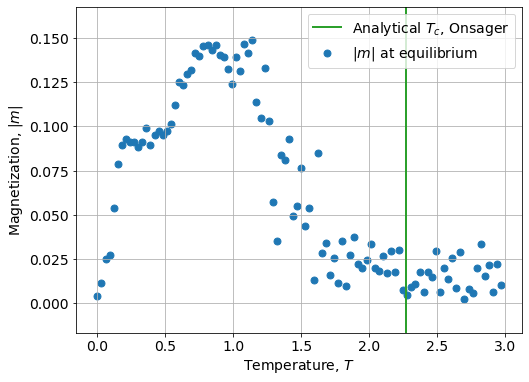

In [39]:
# Plot final lattice
traces = 'problem3_output/N=128/traces/'
path = 'problem3_output/N=128/lattices/'

Ts = []
mean_m = []

for filename in os.listdir(path):
    if filename.endswith(".dat"): 
        data_lat = np.loadtxt(path + filename)
        Temperature = filename.split('_')[0]
        trace_name = Temperature + '_magnetization_trace.dat'
        data_trac = np.loadtxt(traces + trace_name)
        
        T = Temperature.split("=")[1]
        Ts.append(float(T))
        mean_m.append(np.mean(data_trac))
        
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(Ts, np.abs(mean_m), s=48, label=r'$|m|$ at equilibrium')
ax.grid()
ax.set_xlabel(r'Temperature, $T$')
ax.set_ylabel(r'Magnetization, $|m|$')
Tc = 2/np.log(1 + np.sqrt(2))
ax.axvline(Tc, color='C2', linewidth=2, label=r'Analytical $T_c$, Onsager')
ax.legend(loc='best')

/home/eric/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


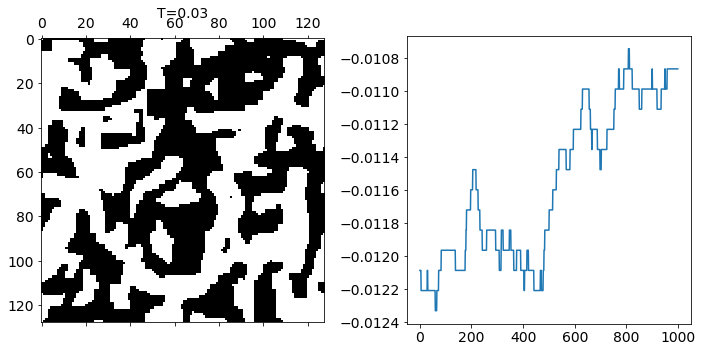

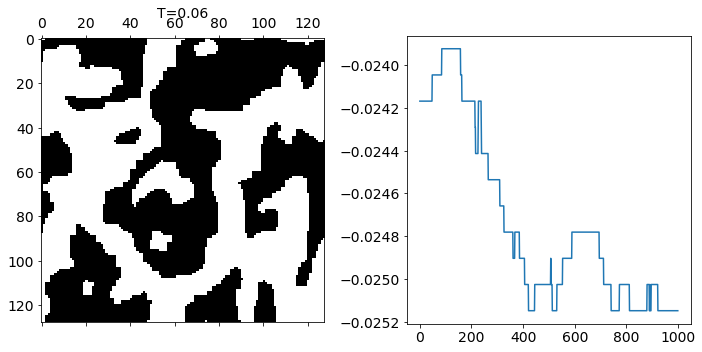

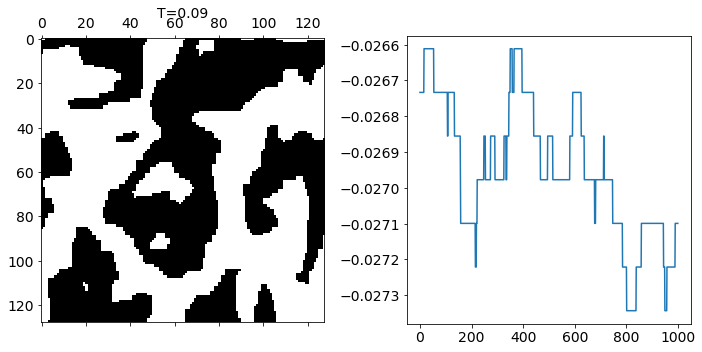

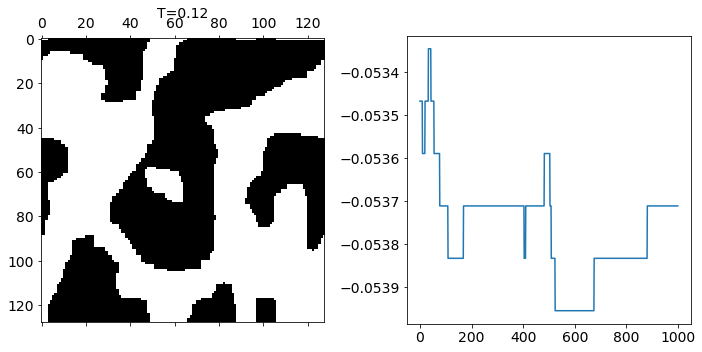

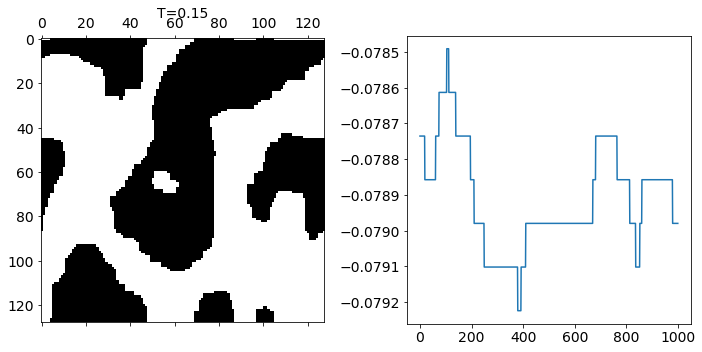

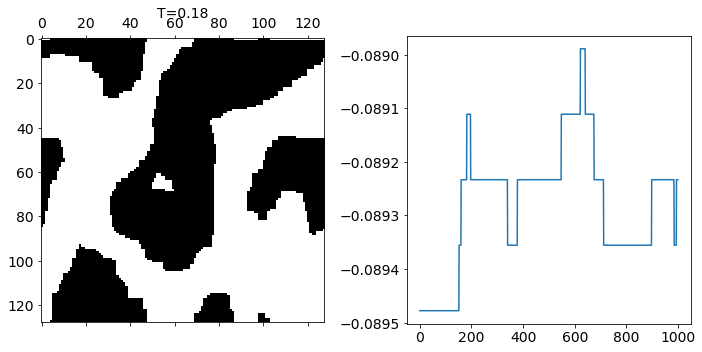

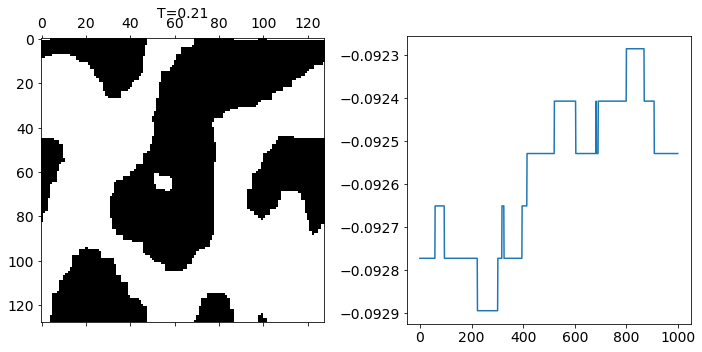

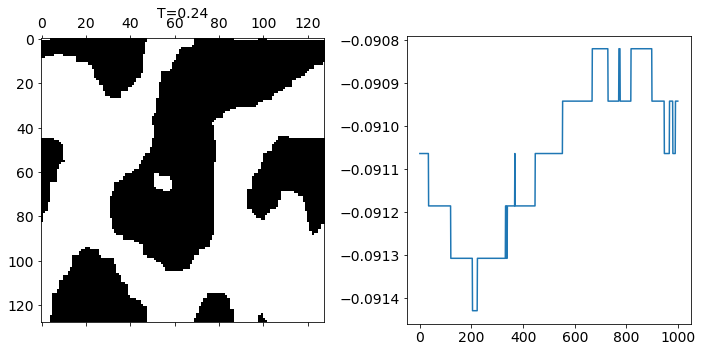

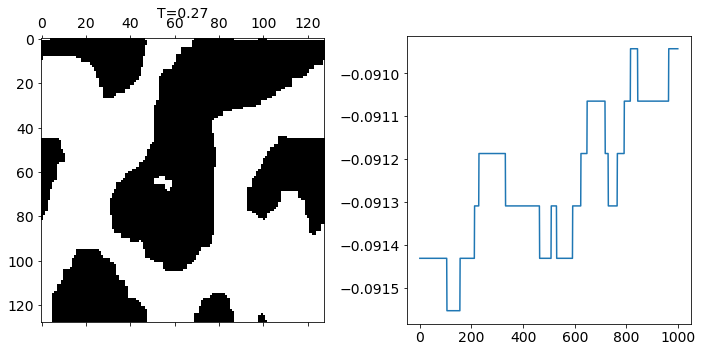

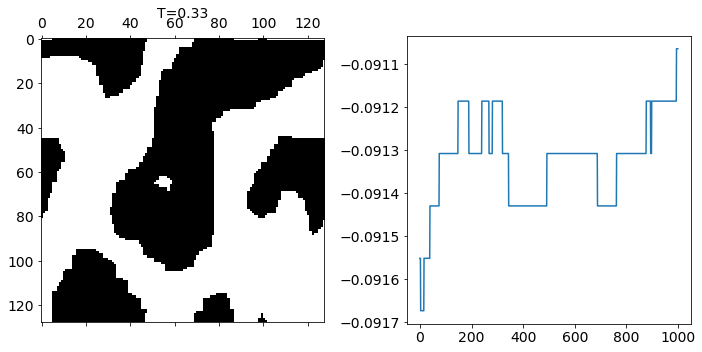

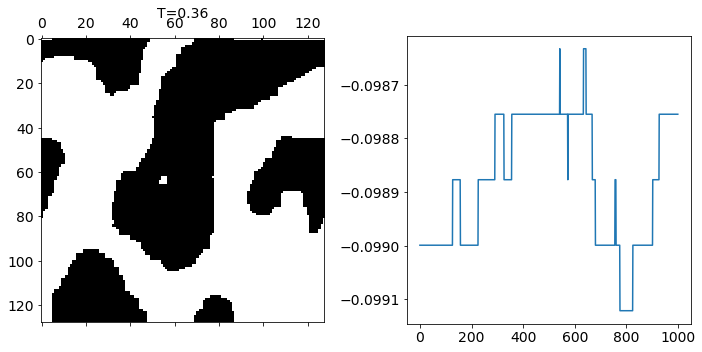

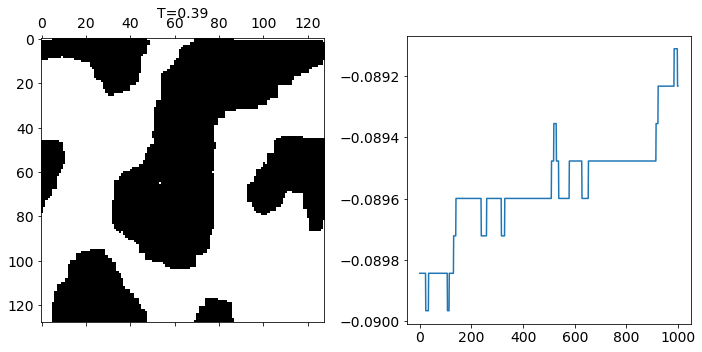

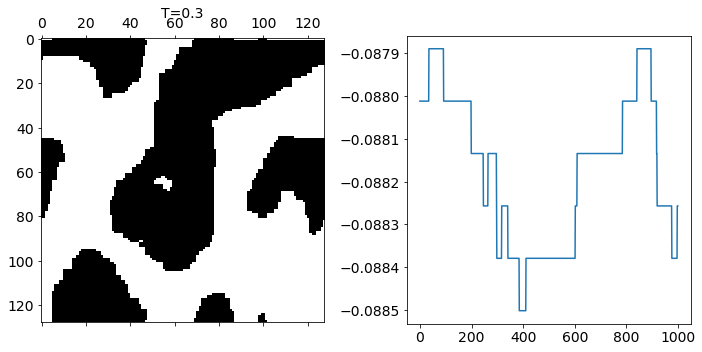

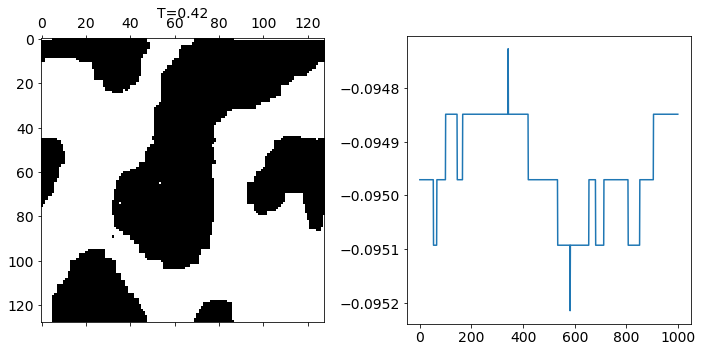

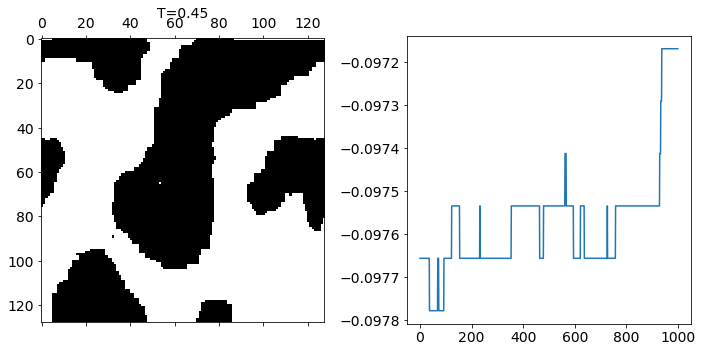

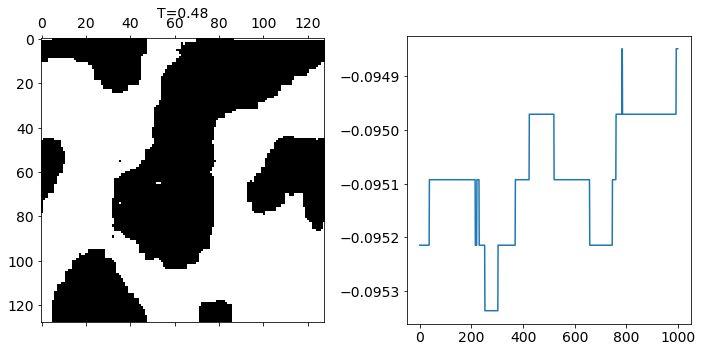

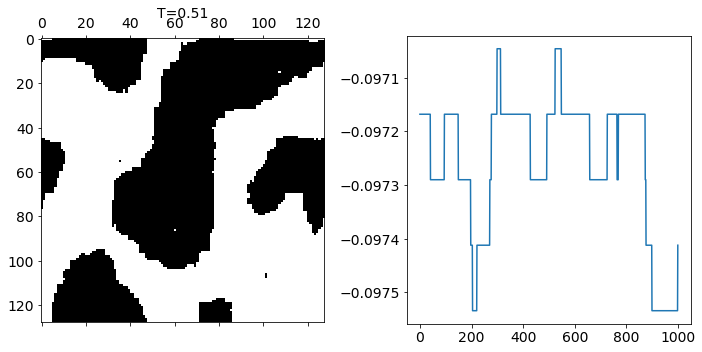

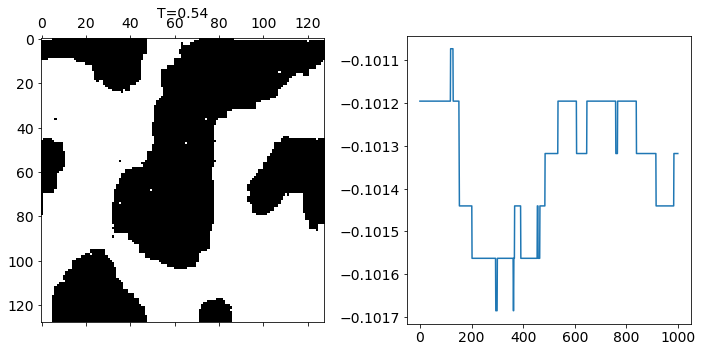

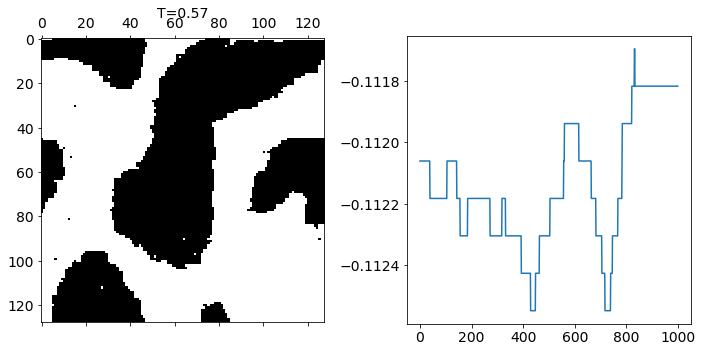

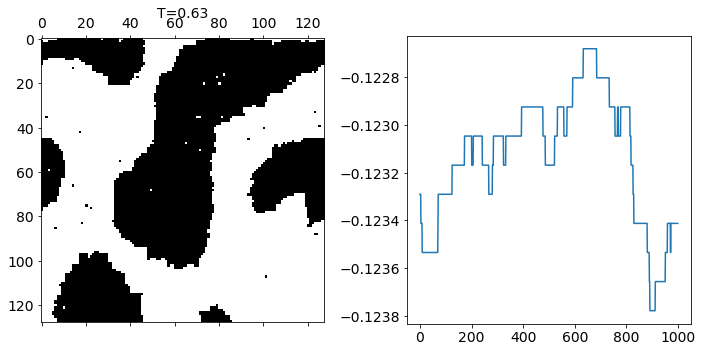

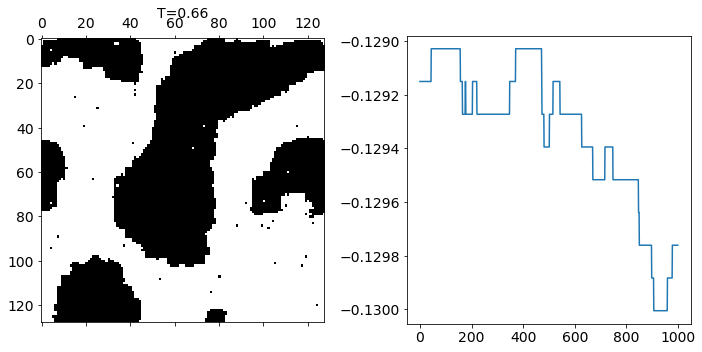

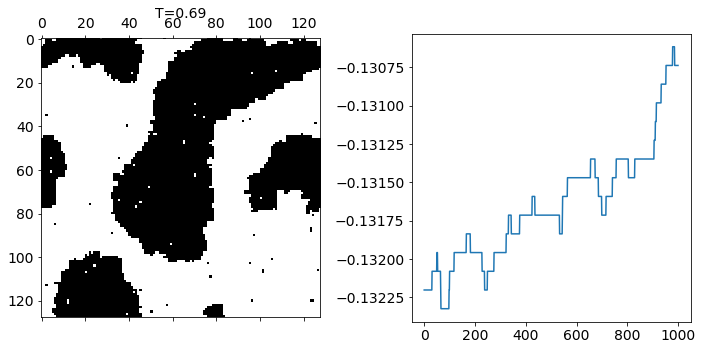

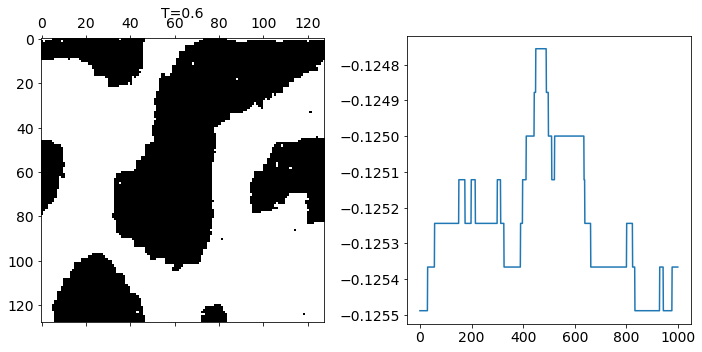

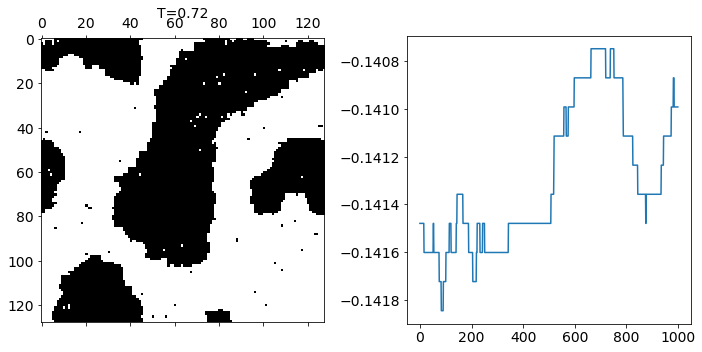

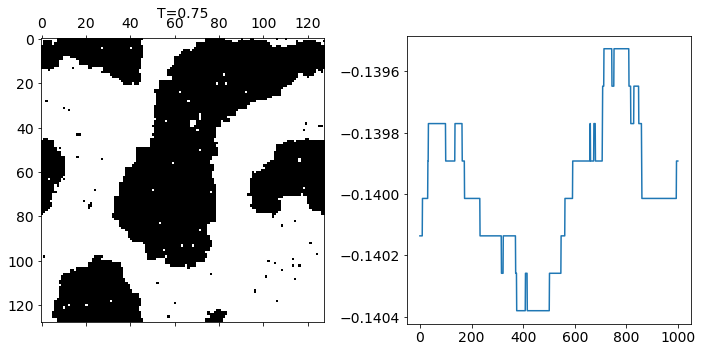

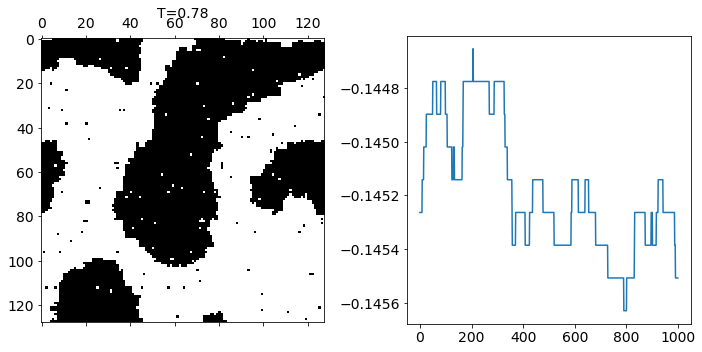

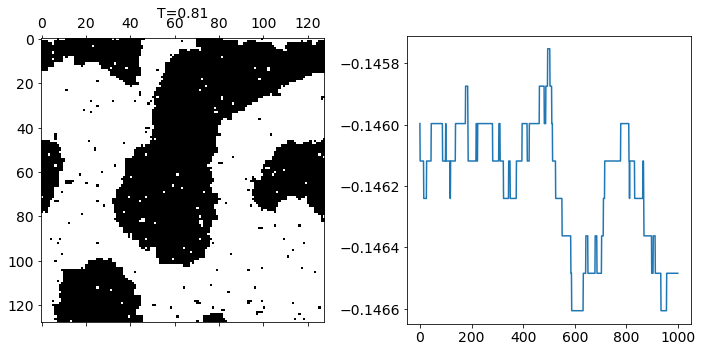

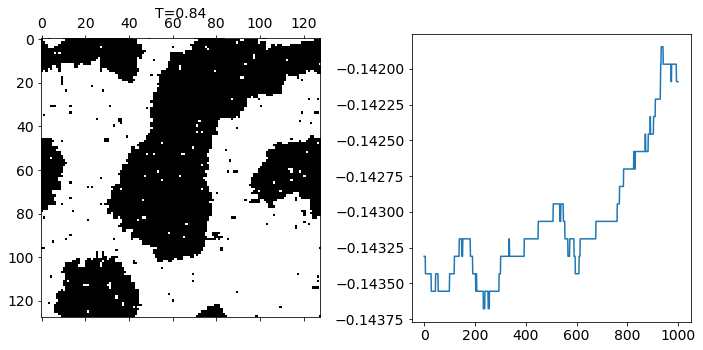

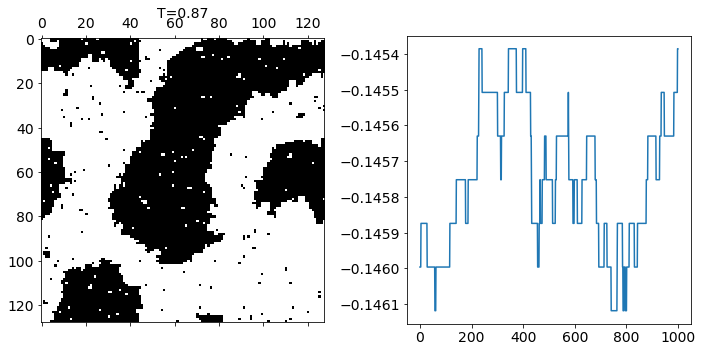

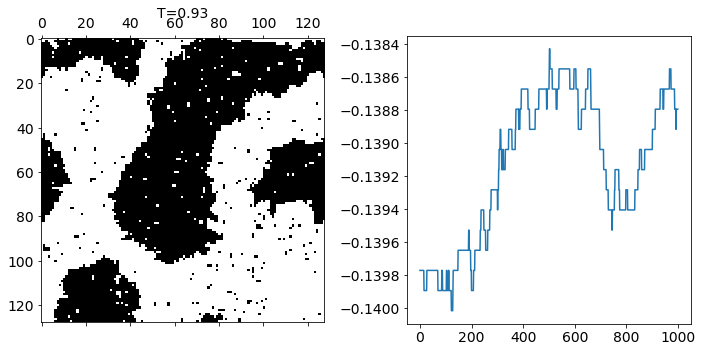

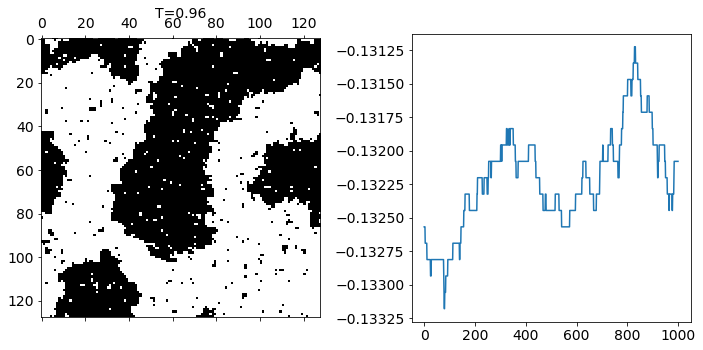

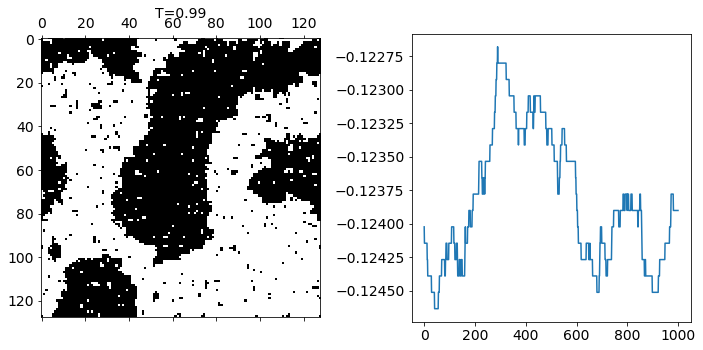

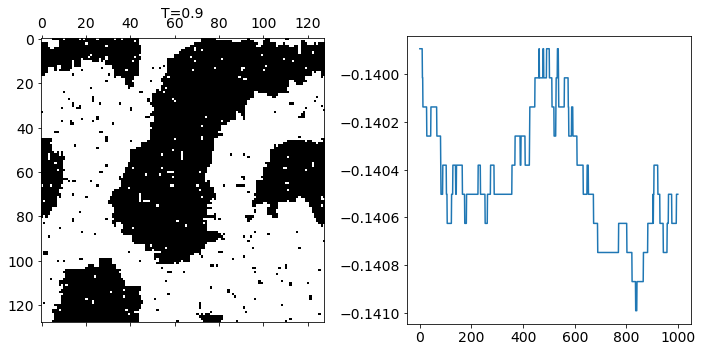

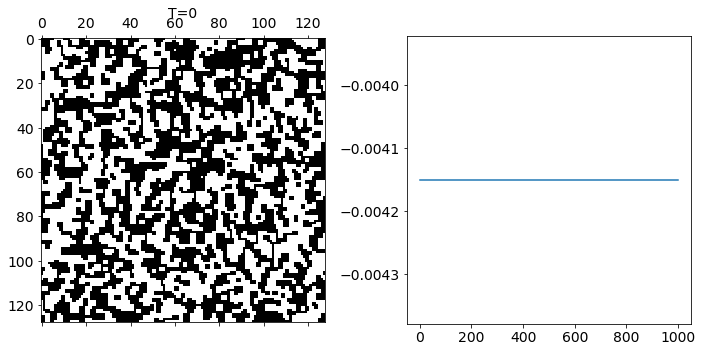

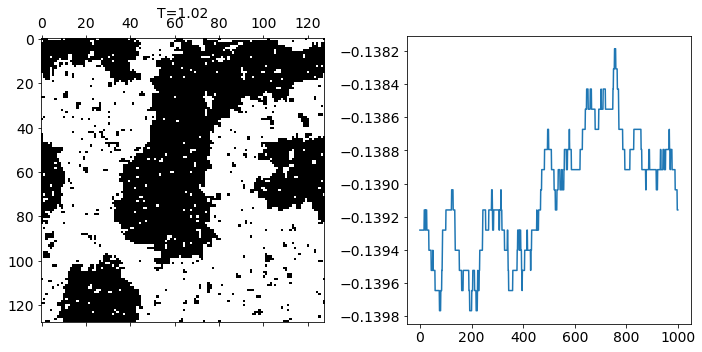

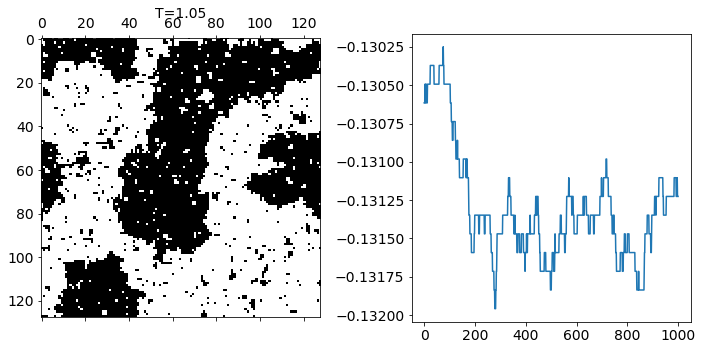

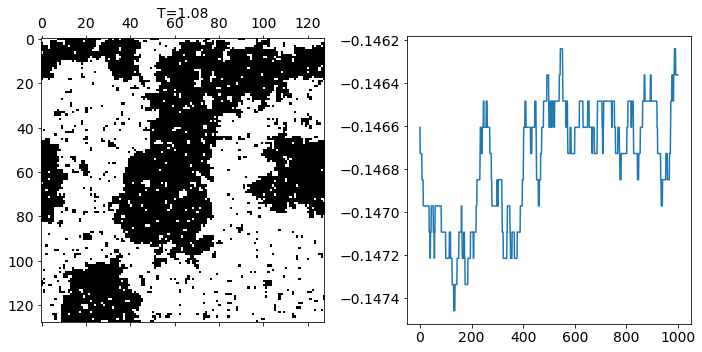

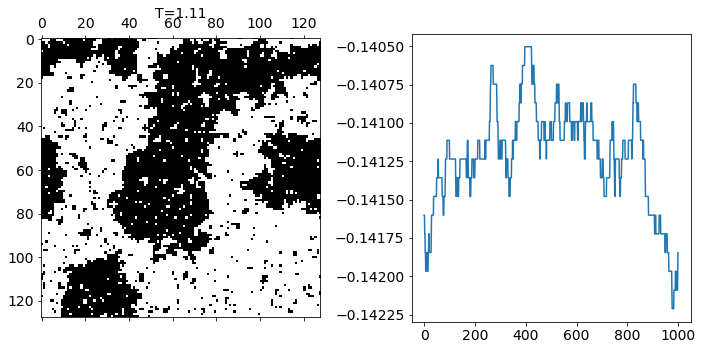

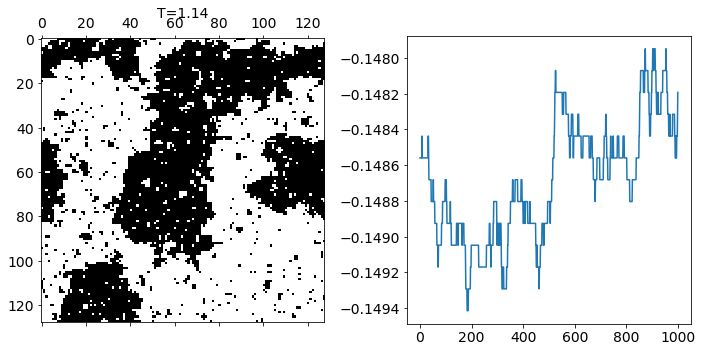

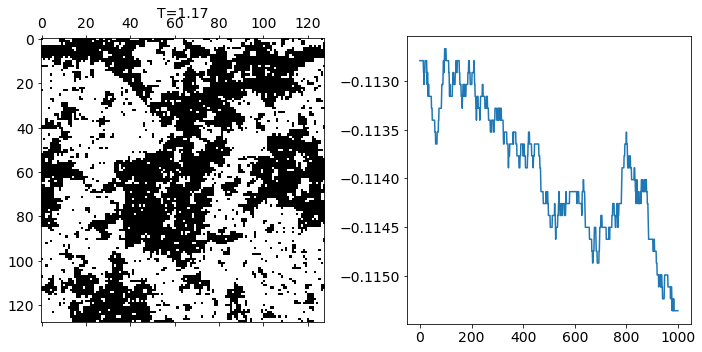

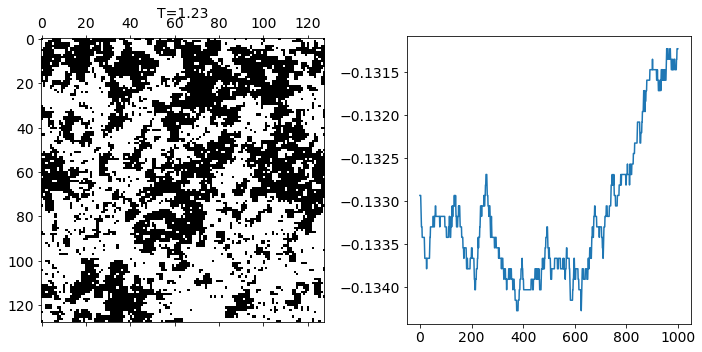

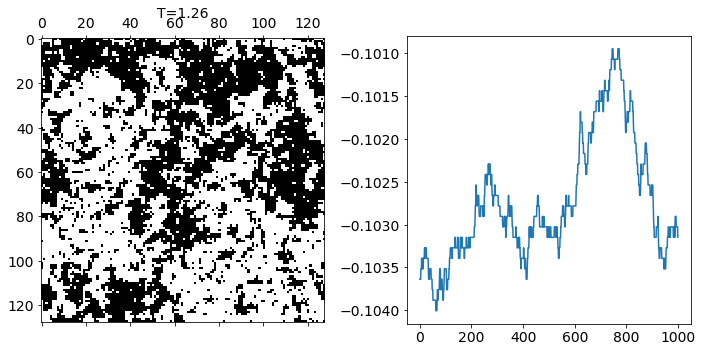

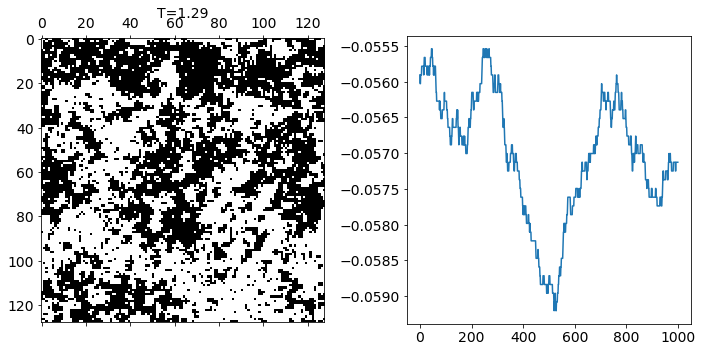

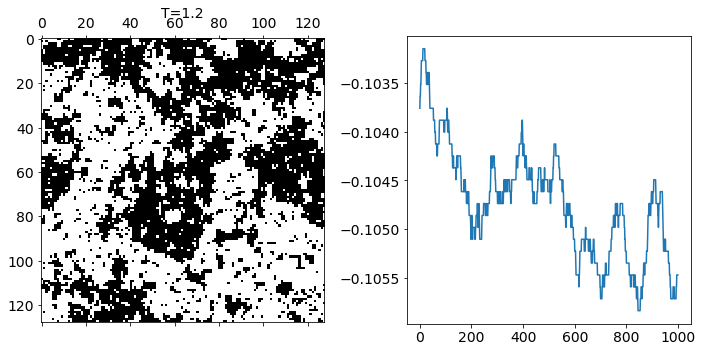

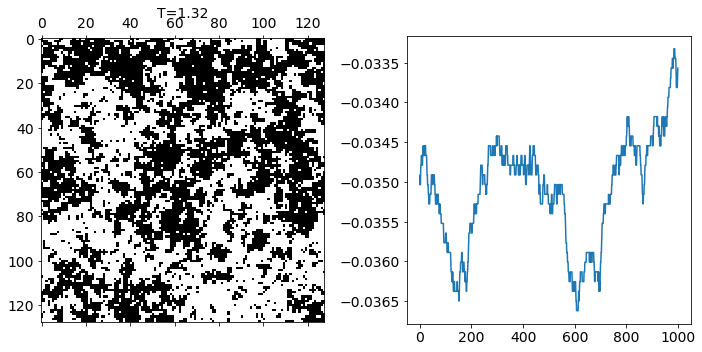

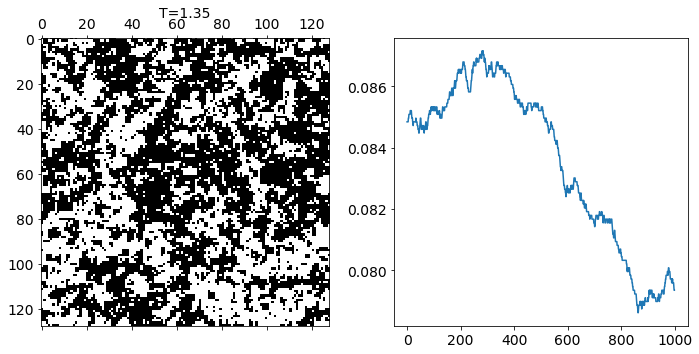

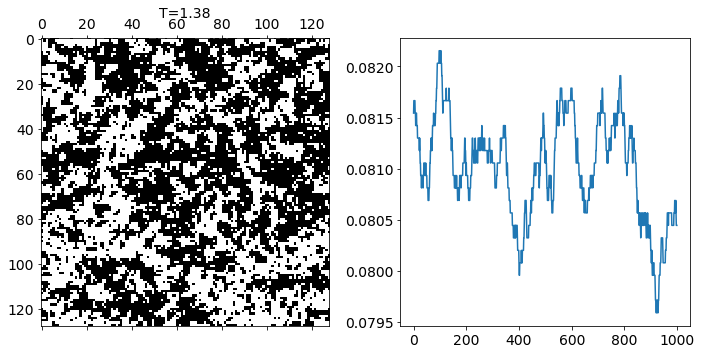

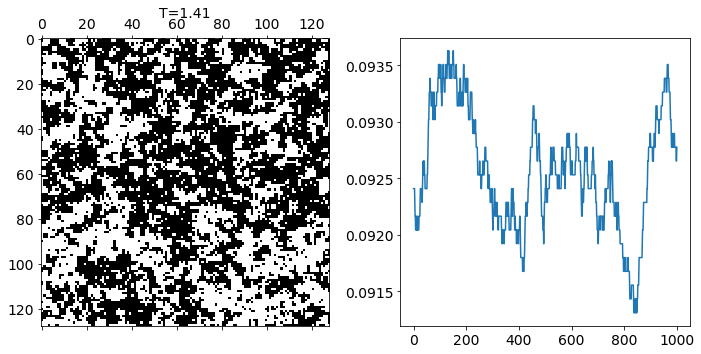

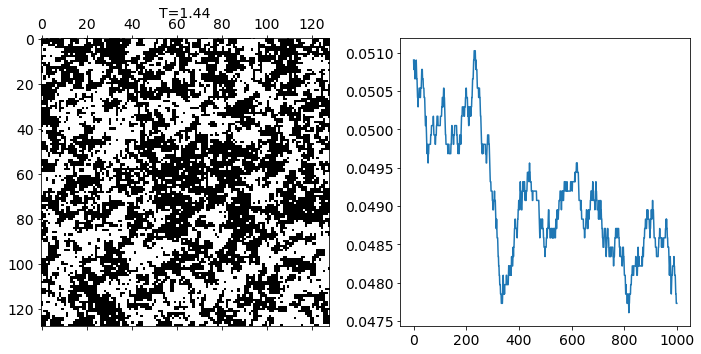

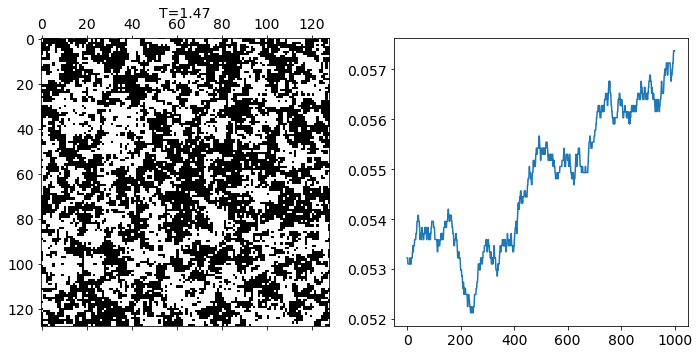

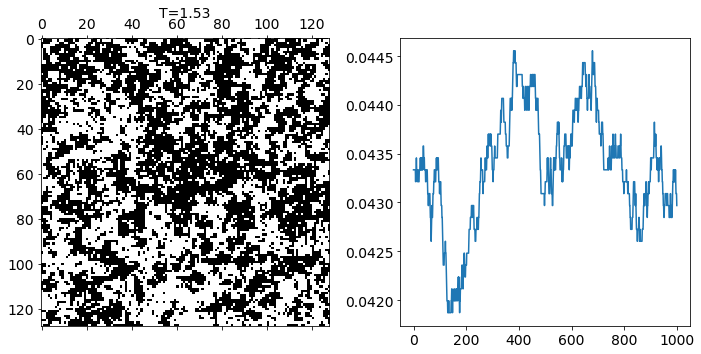

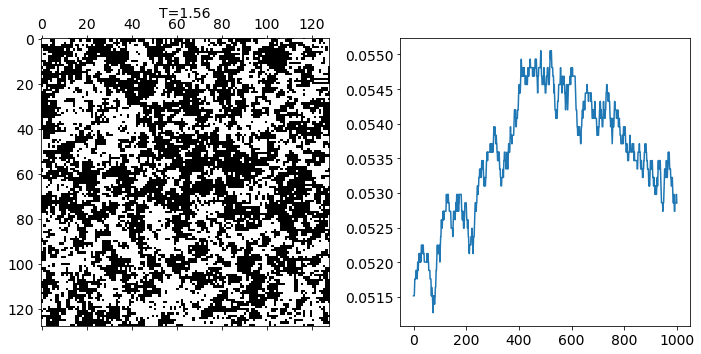

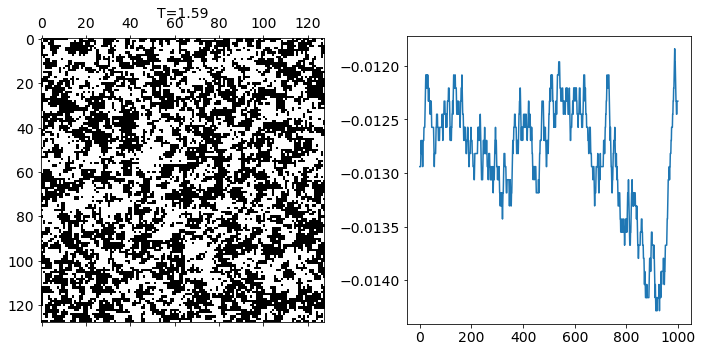

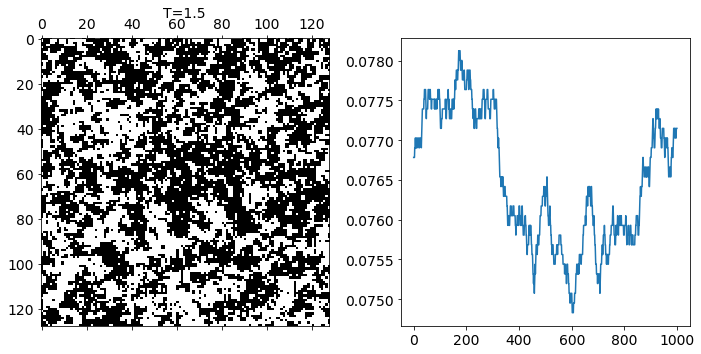

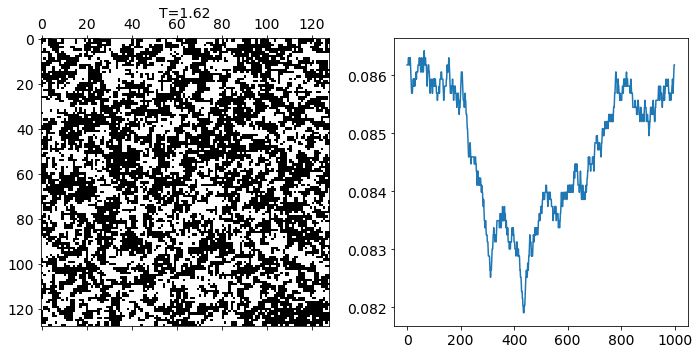

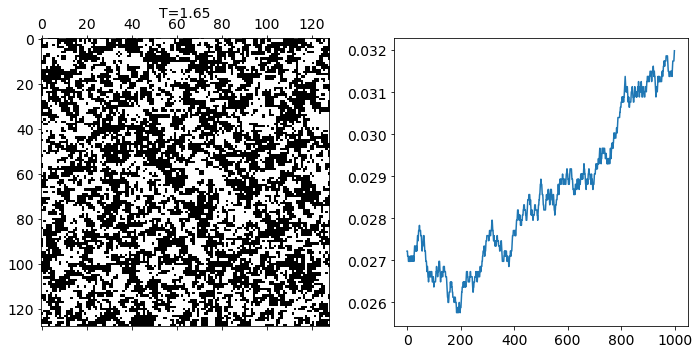

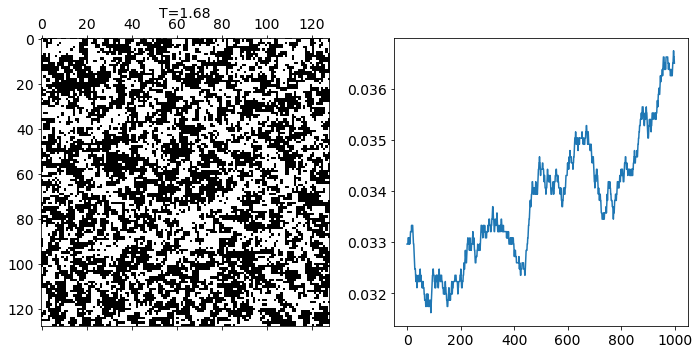

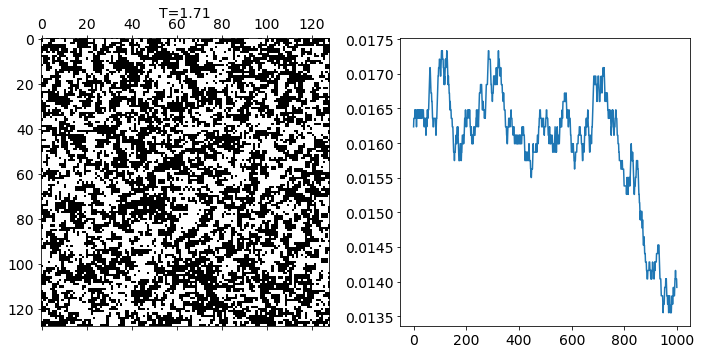

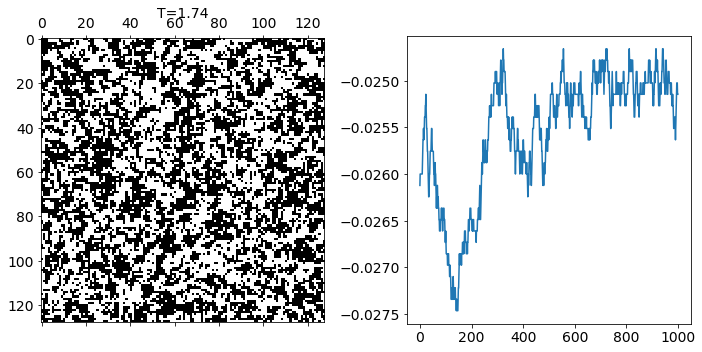

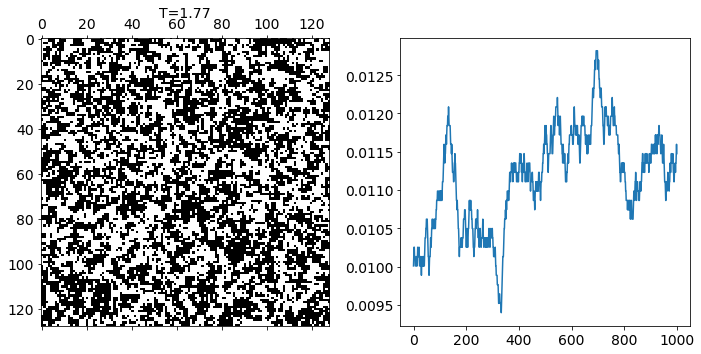

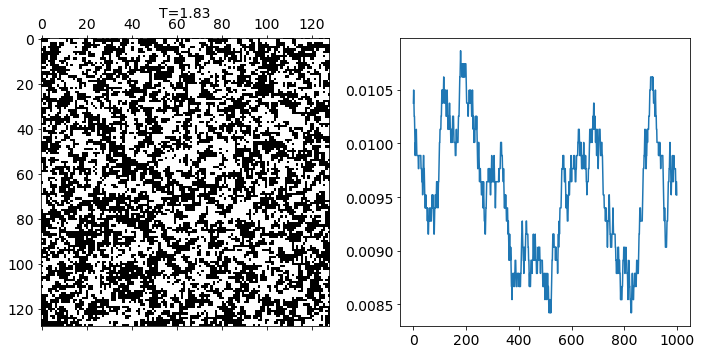

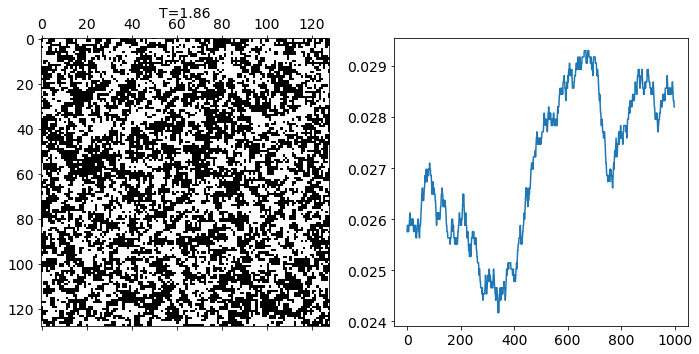

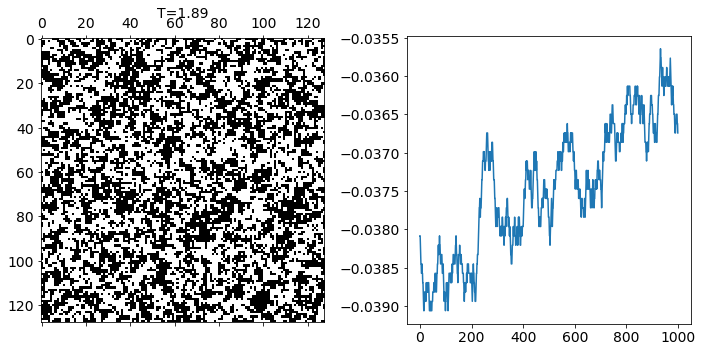

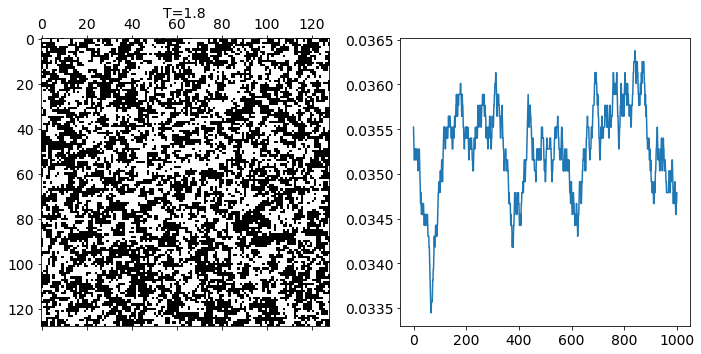

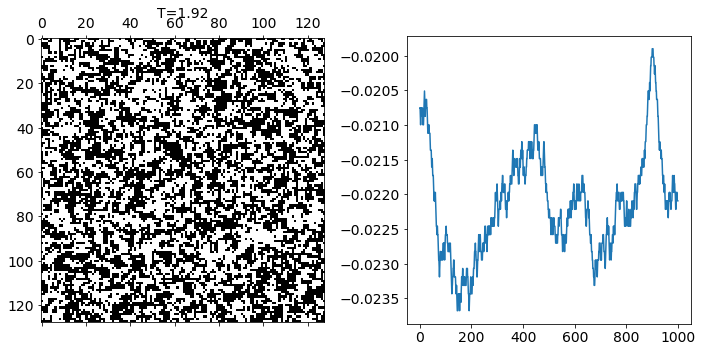

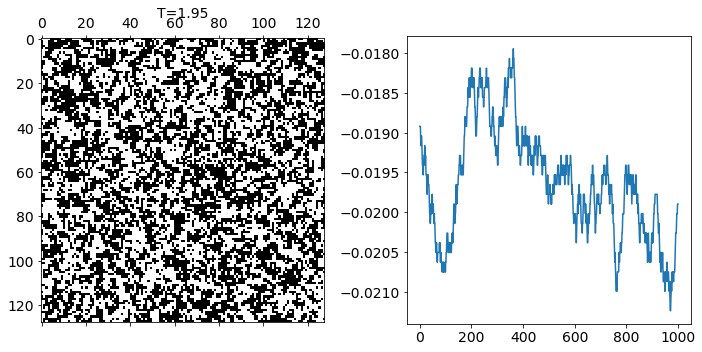

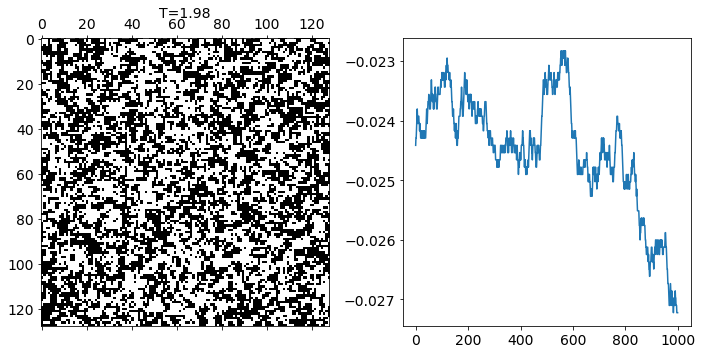

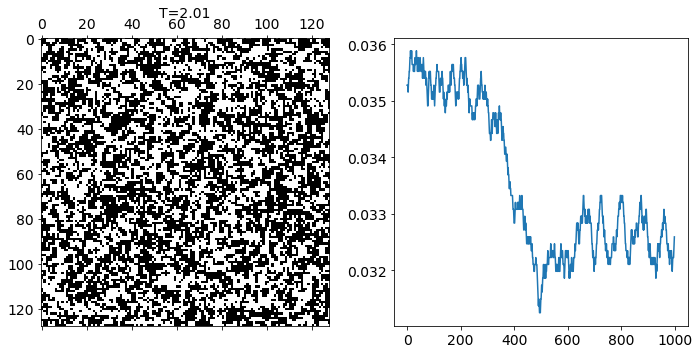

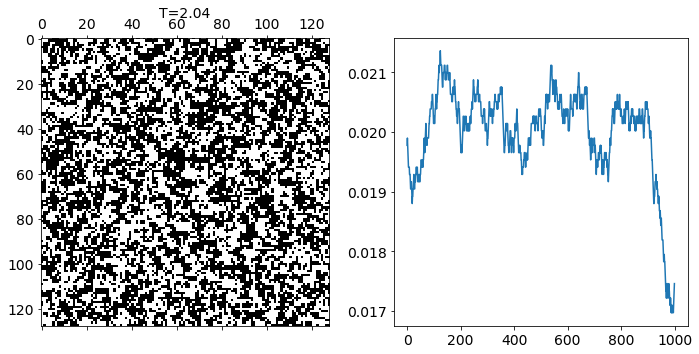

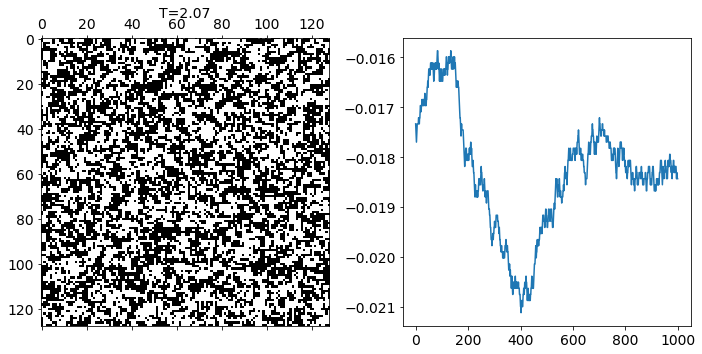

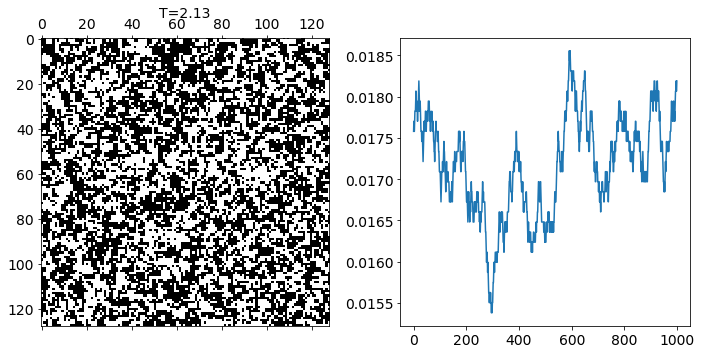

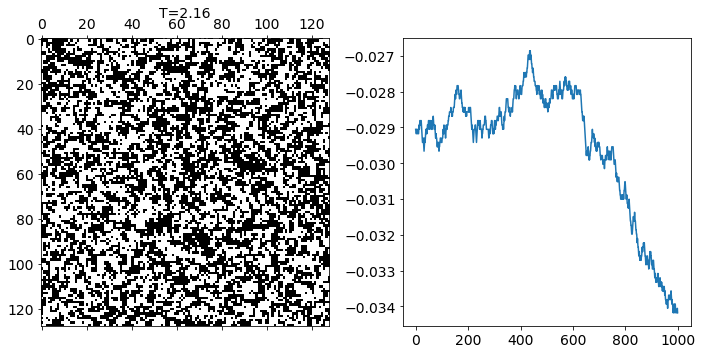

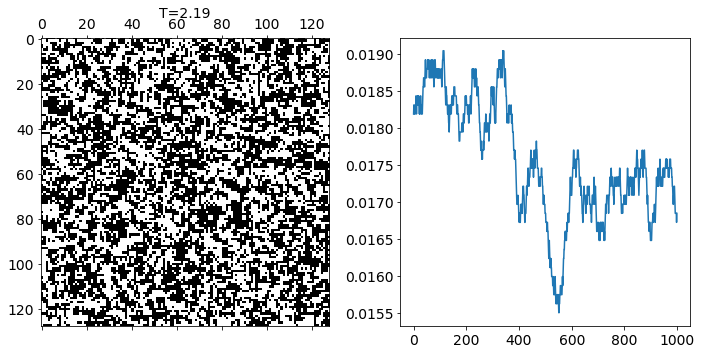

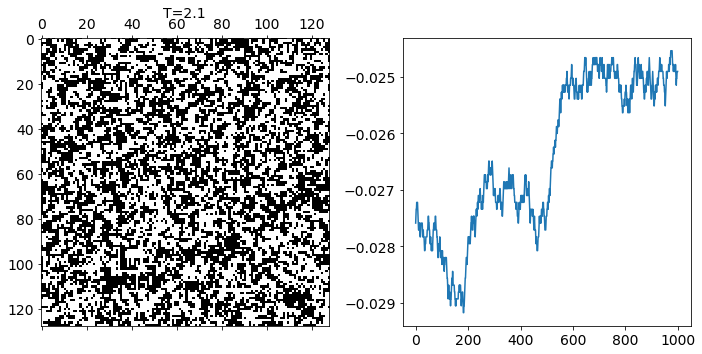

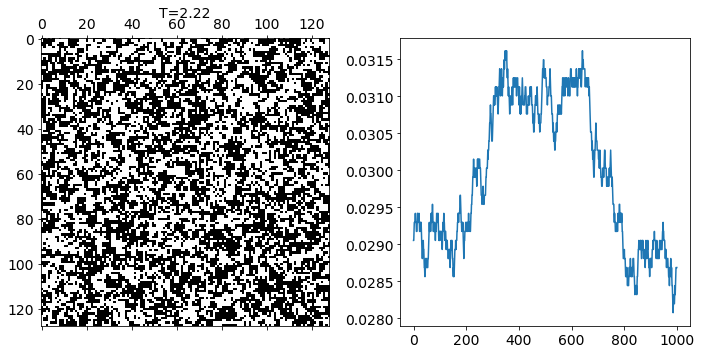

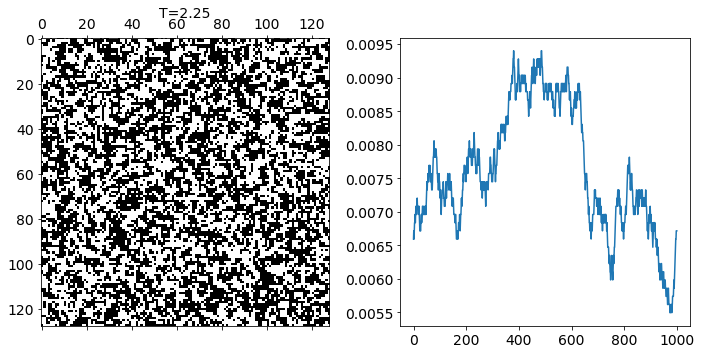

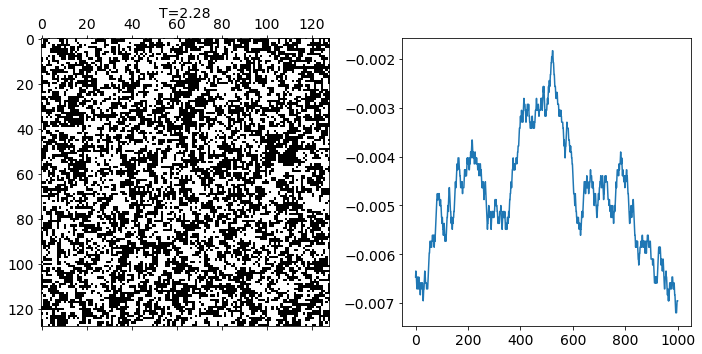

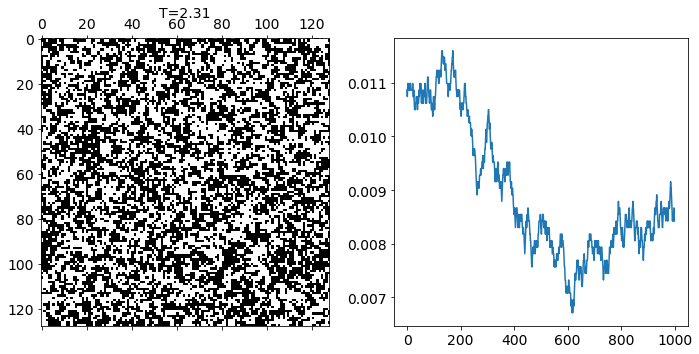

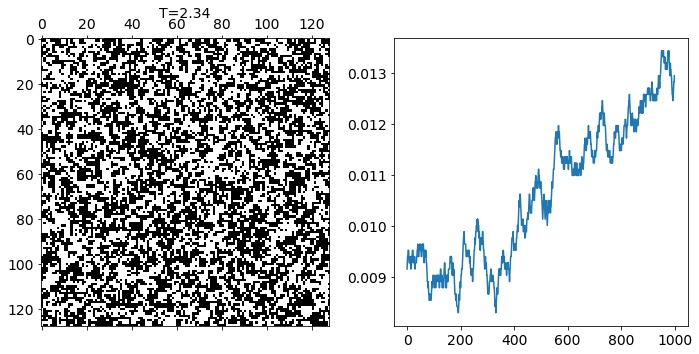

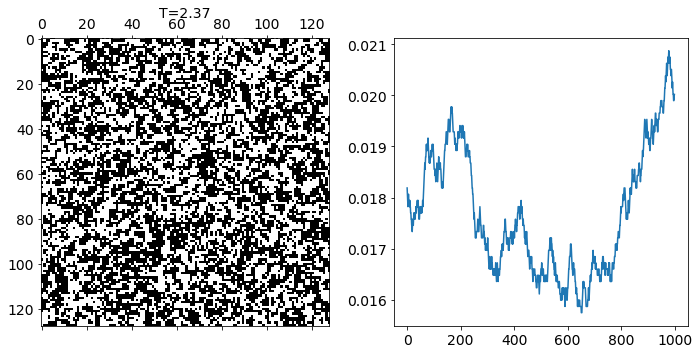

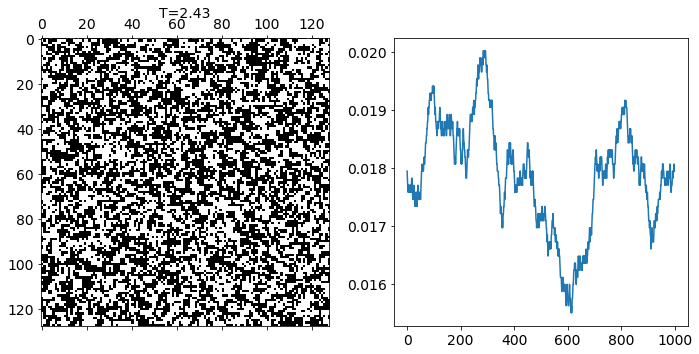

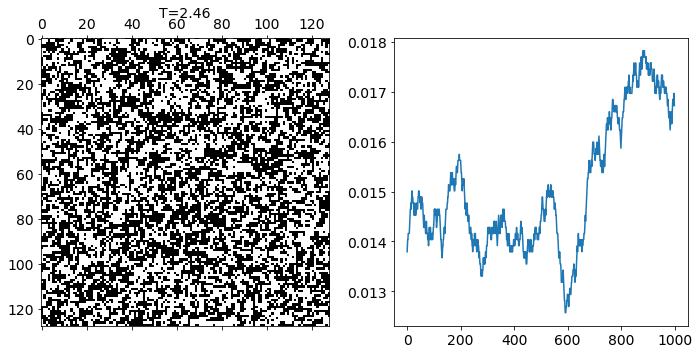

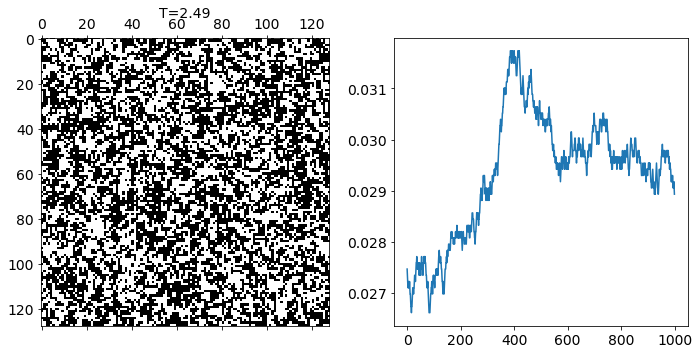

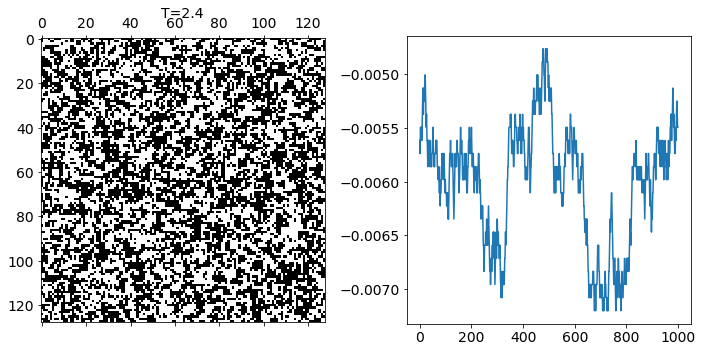

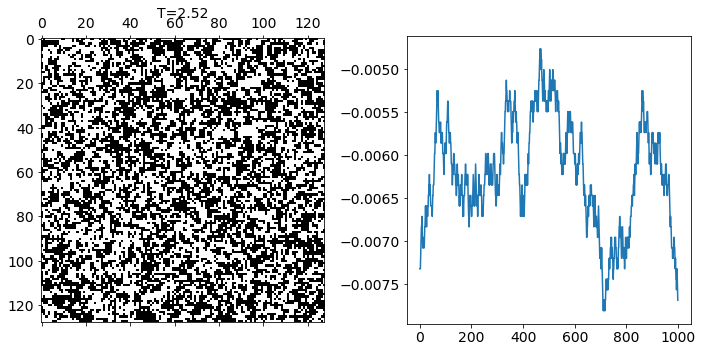

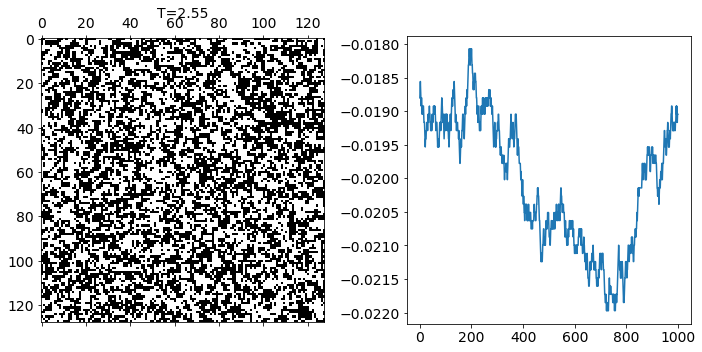

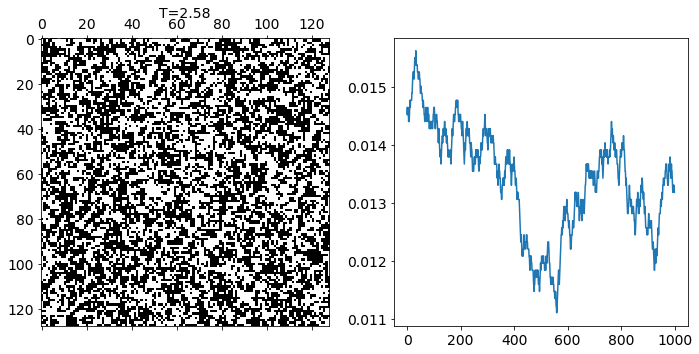

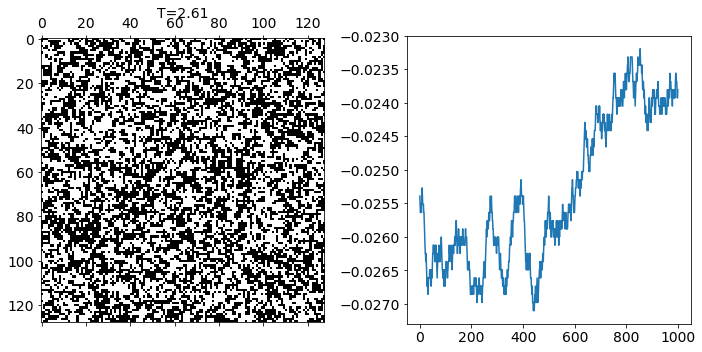

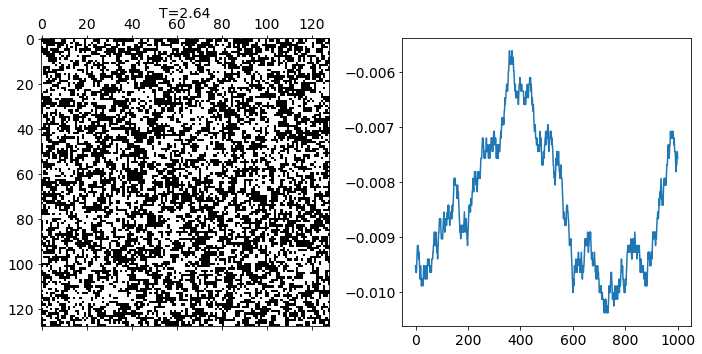

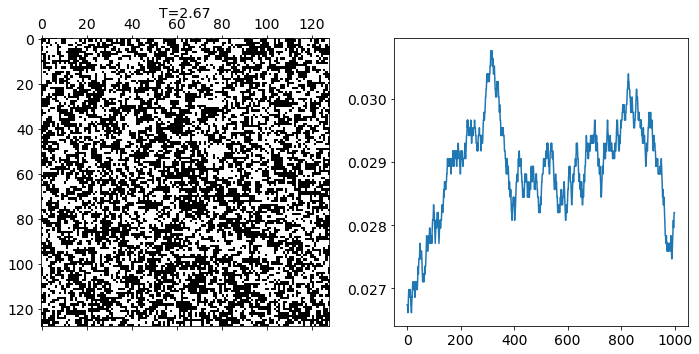

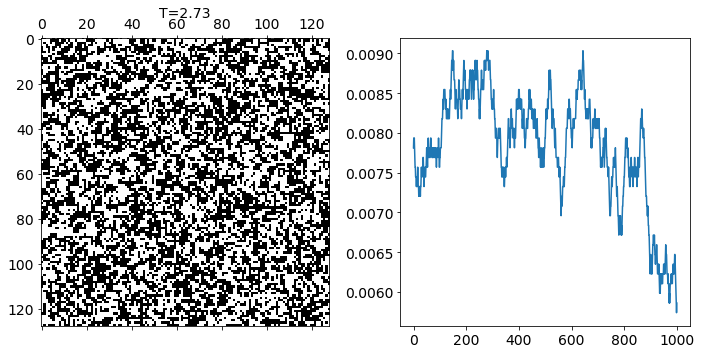

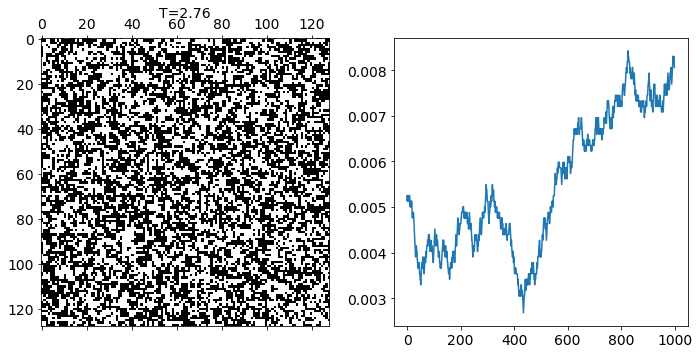

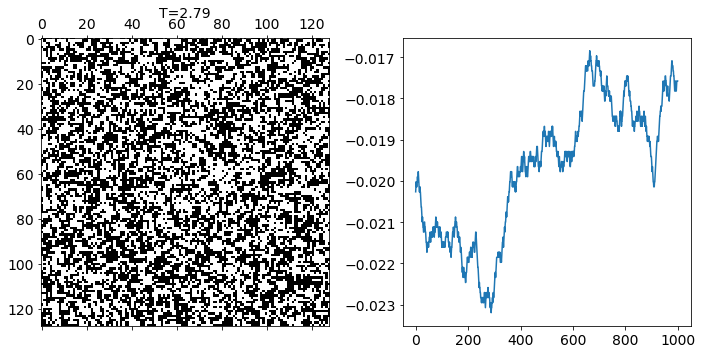

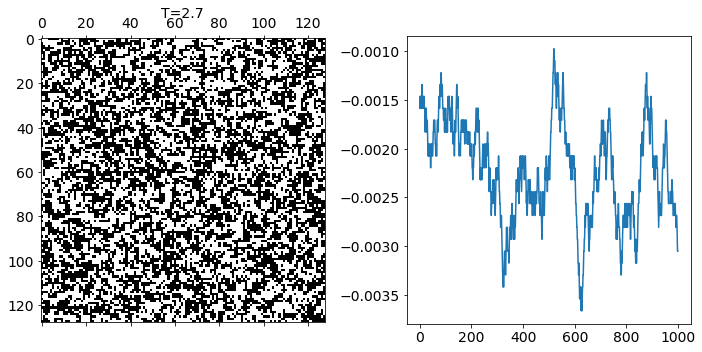

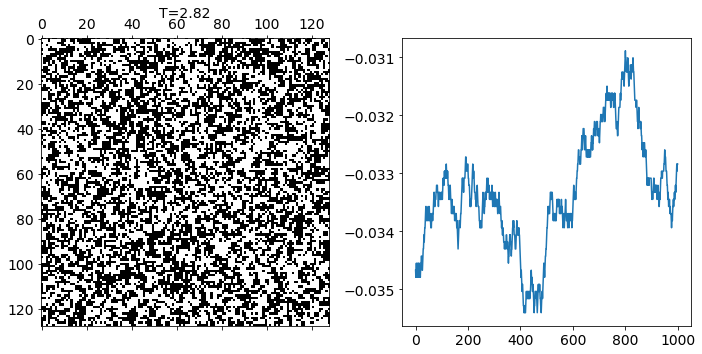

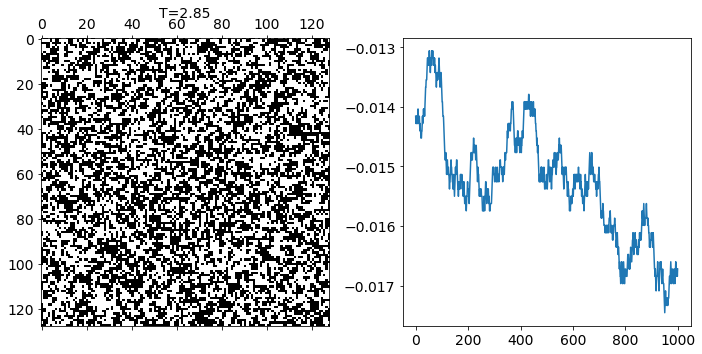

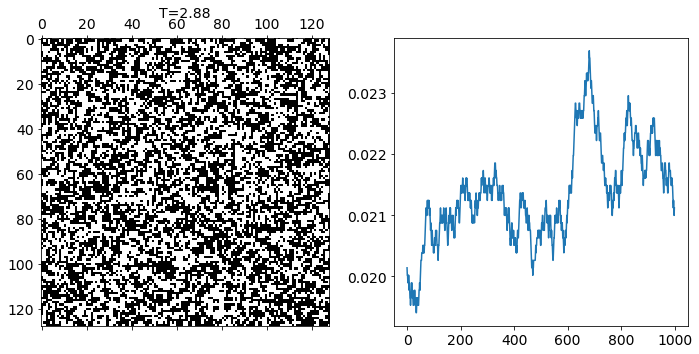

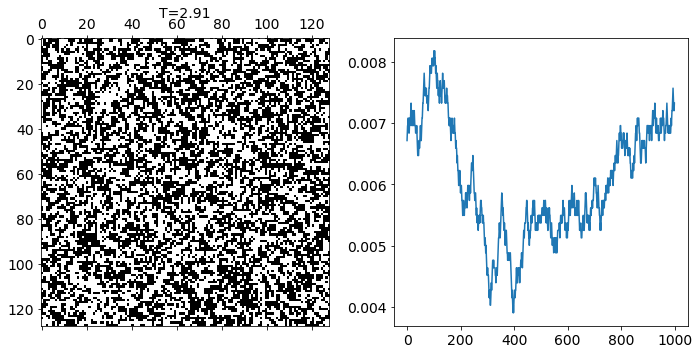

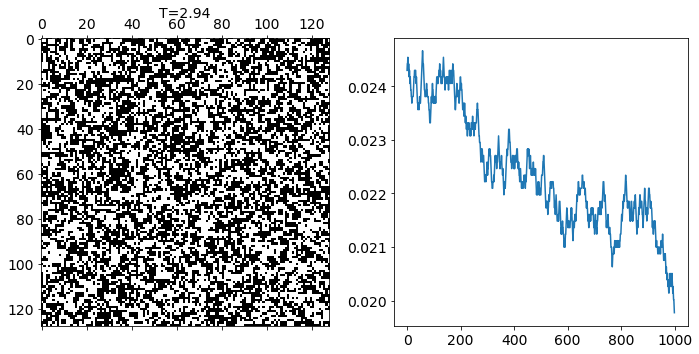

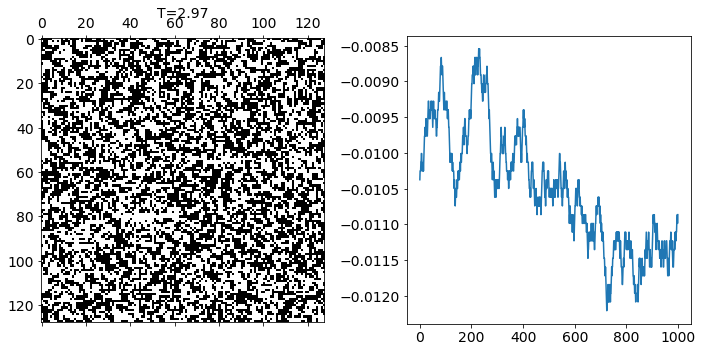

In [40]:
# Plot final lattice
traces = 'problem3_output/N=128/traces/'
path = 'problem3_output/N=128/lattices/'

for filename in os.listdir(path):
    if filename.endswith(".dat"): 
        data_lat = np.loadtxt(path + filename)
        Temperature = filename.split('_')[0]
        trace_name = Temperature + '_magnetization_trace.dat'
        data_trac = np.loadtxt(traces + trace_name)
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].matshow(data_lat, cmap=plt.cm.gray_r)
        ax[1].plot(data_trac[np.where(data_trac != 0)])
        ax[0].set_title(Temperature)
        plt.tight_layout()
